### Data Models

In [1]:
# Install xgboost
# For XBClassifier
!pip install xgboost

In [2]:
# Install imblearn
# For RandomUnderSampler
!pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)


In [3]:
# imports 
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.utils import class_weight

In [4]:
train = pd.read_csv('./datasets/loans_schema_clean.csv')
train.head()

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,...,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees,fully_paid
0,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,NaN,...,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0,0
1,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,NaN,...,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0,0
2,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,NaN,...,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0,0
3,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,NaN,...,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0,0
4,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,...,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0,0


In [5]:
# Correlation Calculation
# Finding columns with correlation to the fully paid in 
train.corrwith(train["fully_paid"])

<ipython-input-5-3f8af3078e70>:3: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corrwith(train["fully_paid"])


emp_length                         -0.000243
annual_income                       0.024685
debt_to_income                     -0.026296
annual_income_joint                 0.023309
debt_to_income_joint               -0.055108
delinq_2y                           0.001025
months_since_last_delinq           -0.030919
earliest_credit_line               -0.004261
inquiries_last_12m                  0.026165
total_credit_lines                  0.034537
open_credit_lines                  -0.002207
total_credit_limit                  0.029942
total_credit_utilized               0.014517
num_collections_last_12m            0.010829
num_historical_failed_to_pay       -0.002599
months_since_90d_late               0.011260
current_accounts_delinq            -0.002163
total_collection_amount_ever       -0.005369
current_installment_accounts       -0.006698
accounts_opened_24m                 0.038746
months_since_last_credit_inquiry   -0.028593
num_satisfactory_accounts          -0.001791
num_accoun

### Setting up the model 

In [6]:
# Check column names 
train.columns

Index(['emp_title', 'emp_length', 'state', 'homeownership', 'annual_income',
       'verified_income', 'debt_to_income', 'annual_income_joint',
       'verification_income_joint', 'debt_to_income_joint', 'delinq_2y',
       'months_since_last_delinq', 'earliest_credit_line',
       'inquiries_last_12m', 'total_credit_lines', 'open_credit_lines',
       'total_credit_limit', 'total_credit_utilized',
       'num_collections_last_12m', 'num_historical_failed_to_pay',
       'months_since_90d_late', 'current_accounts_delinq',
       'total_collection_amount_ever', 'current_installment_accounts',
       'accounts_opened_24m', 'months_since_last_credit_inquiry',
       'num_satisfactory_accounts', 'num_accounts_120d_past_due',
       'num_accounts_30d_past_due', 'num_active_debit_accounts',
       'total_debit_limit', 'num_total_cc_accounts', 'num_open_cc_accounts',
       'num_cc_carrying_balance', 'num_mort_accounts',
       'account_never_delinq_percent', 'tax_liens', 'public_record_bankr

In [7]:
# Creating list of features 
features = [ 'paid_total', 'paid_principal']

In [8]:
# Drop the null values for columns placed in features
train.dropna(subset=features, inplace=True)

In [9]:
# Setting the X and y
X = train[features]
y = train['fully_paid']

In [10]:
# Running the train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state =42)

In [11]:
# Baseline Accuracy
y_train.value_counts(normalize=True)

0    0.957467
1    0.042533
Name: fully_paid, dtype: float64

### Resample Data

In [12]:
# Instantiate RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy = 'auto', random_state=42)

In [13]:
# Fit and resample the training data under new variables 
X_resampled, y_resampled = rus.fit_resample(X_train, y_train.values)

### Logistic Regression

In [14]:
# Define the pipeline
lr_pipe = Pipeline([
    ('ss',StandardScaler(with_mean=False)),
    ('lr', LogisticRegression(class_weight = 'balanced'))
])

In [15]:
# Pipe parameters
lr_pipe_params = {
    'lr__C':[.1],
    
}

In [16]:
# Instantiate Gridsearch
lr_gs = GridSearchCV(lr_pipe, param_grid = lr_pipe_params, n_jobs=-1)

In [17]:
# Fit on training data
lr_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler(with_mean=False)),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced'))]),
             n_jobs=-1, param_grid={'lr__C': [0.1]})

In [18]:
# Accuracy score test
lr_gs.score(X_test, y_test)

0.9728

In [19]:
# Accuracy score train
lr_gs.score(X_train, y_train)

0.9694666666666667

In [20]:
# Getting predictions
y_pred_lr = lr_gs.predict(X_test)

In [21]:
# ROC AUC score 
roc_auc_score(y_test, lr_gs.predict_proba(X_test)[:, 1])

0.9880671637858347

In [22]:
# misclassification rate 
print(1 - lr_gs.score(X_train, y_train))
print(1 - lr_gs.score(X_test, y_test))


0.0305333333333333
0.027200000000000002


In [23]:
# Classification report metrics
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2372
           1       0.67      0.92      0.78       128

    accuracy                           0.97      2500
   macro avg       0.83      0.95      0.88      2500
weighted avg       0.98      0.97      0.97      2500



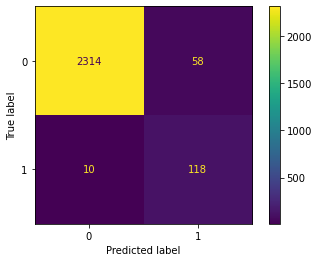

In [24]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test, y_test);

### Confusion Matrix Summary
There were only 10 false positives and 58 false negatives. <br>
It also had a good amount of true positives at 118 and true negatives at 2314.

### Random Forest 

In [25]:
# Define the pipeline
rf_pipe = Pipeline([
    ('ss', StandardScaler(with_mean=False)),
    ('rf', RandomForestClassifier(class_weight = 'balanced'))
])

In [26]:
# Pipe parameters
rf_pipe_params = {
    'rf__n_estimators':[150],
    'rf__max_depth':[2],
    'rf__min_samples_split':[10],
    'rf__ccp_alpha':[0]
}

In [27]:
# Instantiate Gridsearch
rf_gs = GridSearchCV(rf_pipe, param_grid = rf_pipe_params, n_jobs=-1)

In [28]:
# Fit on training data
rf_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler(with_mean=False)),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'rf__ccp_alpha': [0], 'rf__max_depth': [2],
                         'rf__min_samples_split': [10],
                         'rf__n_estimators': [150]})

In [29]:
# Get the best parameters 
rf_gs.best_params_

{'rf__ccp_alpha': 0,
 'rf__max_depth': 2,
 'rf__min_samples_split': 10,
 'rf__n_estimators': 150}

In [30]:
# Accuracy score on test data
rf_gs.score(X_test, y_test)

0.9312

In [31]:
# Accuracy score on the train data
rf_gs.score(X_train, y_train)

0.9398666666666666

In [32]:
# Getting predictions
y_pred_rf = rf_gs.predict(X_test)

In [33]:
# ROC AUC score
roc_auc_score(y_test, rf_gs.predict_proba(X_test)[:, 1])

0.9794905406829679

In [34]:
# misclassification rate
print(1 - rf_gs.score(X_train, y_train))
print(1 - rf_gs.score(X_test, y_test))

0.06013333333333337
0.06879999999999997


In [35]:
# Classification report metrics
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      2372
           1       0.42      0.95      0.58       128

    accuracy                           0.93      2500
   macro avg       0.71      0.94      0.77      2500
weighted avg       0.97      0.93      0.94      2500



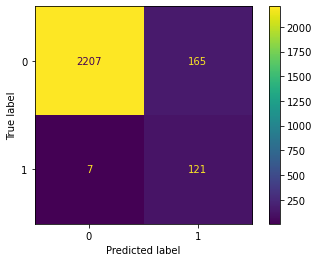

In [36]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf_gs, X_test, y_test);

### Confusion Matrix Summary
There were only 7 false positives but had a lot of false negatives at 165. <br>
It also had a good amount of true positives at 121 and true negatives at 2207.

### KNeighbors Classifier

In [37]:
# Define the pipeline
knn_pipe = Pipeline([
    ('ss', StandardScaler(with_mean=False)),
    ('knn', KNeighborsClassifier())
])

In [38]:
# Pipe parameters 
knn_pipe_params = {
    'knn__n_neighbors':[9],

}

In [39]:
# Instantiate Gridsearch
knn_gs = GridSearchCV(knn_pipe, param_grid = knn_pipe_params, n_jobs=-1)

In [40]:
# Fit resampled data
knn_gs.fit(X_resampled, y_resampled)

GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler(with_mean=False)),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1, param_grid={'knn__n_neighbors': [9]})

In [41]:
# Accuracy score on test
knn_gs.score(X_test, y_test)

0.9664

In [42]:
# Accuracy score on train
knn_gs.score(X_train, y_train)

0.9685333333333334

In [43]:
# Getting predictions
y_pred_knn = knn_gs.predict(X_test)

In [44]:
# ROC AUC score 
roc_auc_score(y_test, knn_gs.predict_proba(X_test)[:, 1])

0.990478103920742

In [45]:
# misclassification rate 
print(1 - knn_gs.score(X_train, y_train))
print(1 - knn_gs.score(X_test, y_test))



0.03146666666666664
0.03359999999999996


In [46]:
# Classification report metrics
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2372
           1       0.61      0.97      0.75       128

    accuracy                           0.97      2500
   macro avg       0.80      0.97      0.86      2500
weighted avg       0.98      0.97      0.97      2500



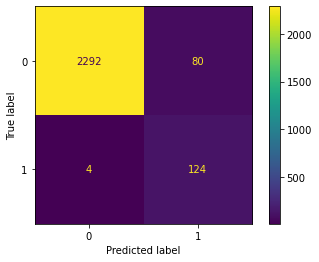

In [47]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(knn_gs, X_test, y_test);

### Confusion Matrix Summary
There were only 4 false positives and 80 false negatives. <br>
It also had a good amount of true positives at 124 and true negatives at 2292.

### Adaboost w/Decison Tree Classifier 

In [48]:
# Define the pipeline
boost_pipe = Pipeline([
    ('ss', StandardScaler(with_mean=False)),
    ('boost', AdaBoostClassifier())
])

In [49]:
# Pipe parameters 
boost_pipe_params = {
    'boost__n_estimators': [30, 50, 70],
    'boost__estimator':[DecisionTreeClassifier()]
}

In [50]:
# Instantiate Gridsearch
ada_boost_gs = GridSearchCV(boost_pipe, param_grid = boost_pipe_params, n_jobs=-1)

In [51]:
# Fit train data
ada_boost_gs.fit(X_resampled, y_resampled)

GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler(with_mean=False)),
                                       ('boost', AdaBoostClassifier())]),
             n_jobs=-1,
             param_grid={'boost__estimator': [DecisionTreeClassifier()],
                         'boost__n_estimators': [30, 50, 70]})

In [52]:
# Accuracy score test 
ada_boost_gs.score(X_test, y_test)

0.9768

In [53]:
# Accuracy score on train
ada_boost_gs.score(X_train, y_train)

0.9798666666666667

In [54]:
# Getting predictions
y_pred_boost = ada_boost_gs.predict(X_test)

In [55]:
roc_auc_score(y_test, ada_boost_gs.predict_proba(X_test)[:, 1])

0.9729922006745362

In [56]:
# misclassification rate 
print(1 - ada_boost_gs.score(X_train, y_train))
print(1 - ada_boost_gs.score(X_test, y_test))


0.020133333333333336
0.0232


In [57]:
print(classification_report(y_test, y_pred_boost))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2372
           1       0.70      0.97      0.81       128

    accuracy                           0.98      2500
   macro avg       0.85      0.97      0.90      2500
weighted avg       0.98      0.98      0.98      2500



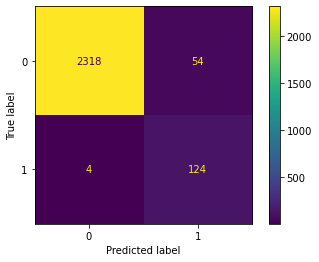

In [58]:
ConfusionMatrixDisplay.from_estimator(ada_boost_gs, X_test, y_test);

### Confusion Matrix Summary
There were only 4 false positives and 49 false negatives. <br>
It also had a good amount of true positives at 124 and true negatives at 2323.

### Multinomial Naive Bayes

In [59]:
# Define the pipeline
bayes_pipe = Pipeline([
    ('ss', StandardScaler(with_mean=False)),
    ('clf', MultinomialNB())
])

In [60]:
# Pipe parameters
bayes_pipe_params = {
    'clf__alpha': (0.1, 0.5, 1.0)
}

In [61]:
# Instantiate Gridsearch
bayes_gs = GridSearchCV(bayes_pipe, param_grid = bayes_pipe_params, n_jobs=-1)

In [62]:
# Fit train data
bayes_gs.fit(X_resampled, y_resampled)

GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler(with_mean=False)),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1, param_grid={'clf__alpha': (0.1, 0.5, 1.0)})

In [63]:
# Accuracy score test 
bayes_gs.score(X_test, y_test)

0.8252

In [64]:
# Accuracy score on train
bayes_gs.score(X_train, y_train)

0.8358666666666666

In [65]:
# Getting predictions
y_pred_bayes = bayes_gs.predict(X_test)

In [66]:
# ROC AUC score 
roc_auc_score(y_test, bayes_gs.predict_proba(X_test)[:, 1])

0.9978130269814502

In [67]:
# misclassification rate 
print(1 - bayes_gs.score(X_train, y_train))
print(1 - bayes_gs.score(X_test, y_test))


0.16413333333333335
0.17479999999999996


In [68]:
# Classification report metrics
print(classification_report(y_test, y_pred_bayes))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90      2372
           1       0.23      1.00      0.37       128

    accuracy                           0.83      2500
   macro avg       0.61      0.91      0.63      2500
weighted avg       0.96      0.83      0.87      2500



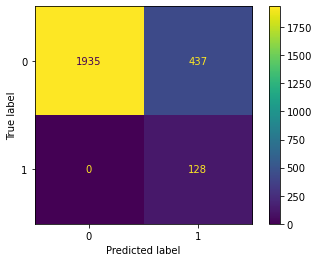

In [69]:
# Confusion Matrix 
ConfusionMatrixDisplay.from_estimator(bayes_gs, X_test, y_test);

### Confusion Matrix Summary
There were 0 false positives but a lot of false negatives at 437. <br>
It also had a a lot of true positives at 128 and true negatives at 1935.

### XG Boost

In [70]:
# Define the pipeline
xg_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('xgb', XGBClassifier())
])

In [71]:
# Pipe parameters
xg_pipe_params = {
    'xgb__n_estimators': [50, 100, 150],
    'xgb__learning_rate': [0.01, 0.1, 0.5]
}

In [72]:
# Instantiate Gridsearch
xg_gs = GridSearchCV(xg_pipe, param_grid = xg_pipe_params, n_jobs=-1)

In [73]:
# Fit train data
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)
xg_gs.fit(X_train, y_train,)

GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      intera...
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__learning_rate': [0.01, 0.1, 0.5],
                         'xgb__n_estimators': [50, 100, 150]})

In [74]:
# Accuracy score test 
xg_gs.score(X_test, y_test)

0.9892

In [75]:
# Accuracy score on train
xg_gs.score(X_train, y_train)

0.9998666666666667

In [76]:
# Getting predictions
y_pred_xg = xg_gs.predict(X_test)

In [77]:
# ROC AUC score
roc_auc_score(y_test, xg_gs.predict_proba(X_test)[:, 1])

0.9958269656408094

In [78]:
# misclassification rate 
print(1 - xg_gs.score(X_train, y_train))
print(1 - xg_gs.score(X_test, y_test))

0.00013333333333331865
0.010800000000000032


In [79]:
# Classification report metrics
print(classification_report(y_test, y_pred_xg))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2372
           1       0.90      0.88      0.89       128

    accuracy                           0.99      2500
   macro avg       0.95      0.94      0.94      2500
weighted avg       0.99      0.99      0.99      2500



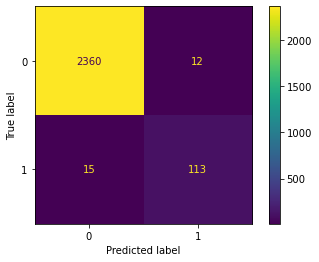

In [80]:
# Confusion Matrix 
ConfusionMatrixDisplay.from_estimator(xg_gs, X_test, y_test);

### Confusion Matrix Summary
There were only 15 false positives and 12 false negatives. <br>
It also had a good amount of true positives at 113 and true negatives at 2360.

### Conclusions
All 6 models performed reasonably well with accuracy scores over 80%. <br>
The model that performed the worst was Multinomial Naive Bayes as it had the most false negatives. <br>
Every model had an auc score of above .90 and low misclassification rates so they performed well. <br>
The model that performed the best was the XG Boost Classifier with an accuracy score of 98%. <br>
XG Boost Classifier also has lowest false positives at 15, lowest false negatives at 12, and highest true negatives at 2360.

### Recommendations
The XG boost model performed well so it is ready for deployment to predict a fully paid loan status <br>
For next steps perhaps more data could be gathered to see if the accuracy scores are affected <br>
More data would also serve to improve the Multinomial Naive Bayes model performance <br>
Additionally, perhaps for Wells Fargo branches in the top 4 states for the amount of fully paid loans: California, Texas, New York, and Florida the loan data could be studied in branches located in those states to see if there is a way to improve the amount of fully paid loans in the other 33 states Wells Fargo is located in the USA.